In [1]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()          

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  7% |  1% |


In [2]:
from torchvision.datasets.utils import download_url

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./oxford-102-flowers.tgz


In [3]:
import tarfile

# Extract from archive
with tarfile.open('./oxford-102-flowers.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
import os

DATA_DIR = './data/oxford-102-flowers/jpg'

files = os.listdir(DATA_DIR)
files[:5]

['image_04892.jpg',
 'image_01840.jpg',
 'image_04227.jpg',
 'image_02449.jpg',
 'image_00533.jpg']

In [5]:
classes = ['pink primrose',
'hard-leaved pocket orchid',
'canterbury bells',
'sweet pea',
'english marigold',
'tiger lily',
'moon orchid',
'bird of paradise',
'monkshood',
'globe thistle',
'snapdragon',
'colts foot',
'king protea',
'spear thistle',
'yellow iris',
'globe-flower',
'purple coneflower',
'peruvian lily',
'balloon flower',
'giant white arum lily',
'fire lily',
'pincushion flower',
'fritillary',
'red ginger',
'grape hyacinth',
'corn poppy',
'prince of wales feathers',
'stemless gentiana',
'artichoke',
'sweet william',
'carnation',
'garden phlox',
'love in the mist',
'mexican aster',
'alpine sea holly',
'ruby-lipped cattleya',
'cape flower',
'great masterwort',
'siam tulip',
'lenten rose',
'barbeton daisy',
'daffodil',
'sword lily',
'poinsettia',
'bolero deep blue',
'wallflower',
'marigold',
'buttercup',
'oxeye daisy',
'common dandelion',
'petunia',
'wild pansy',
'primula',
'sunflower',
'pelargonium',
'bishop of llandaff',
'gaura',
'geranium',
'orange dahlia',
'pink-yellow dahlia',
'cautleya spicata',
'japanese anemone',
'black-eyed susan',
'silverbush',
'californian poppy',
'osteospermum',
'spring crocus',
'bearded iris',
'windflower',
'tree poppy',
'gazania',
'azalea',
'water lily',
'rose',
'thorn apple',
'morning glory',
'passion flower',
'lotus',
'toad lily',
'anthurium',
'frangipani',
'clematis',
'hibiscus',
'columbine',
'desert-rose',
'tree mallow',
'magnolia',
'cyclamen',
'watercress',
'canna lily',
'hippeastrum',
'bee balm',
'ball moss',
'foxglove',
'bougainvillea',
'camellia',
'mallow',
'mexican petunia',
'bromeliad',
'blanket flower',
'trumpet creeper',
'blackberry lily',]

In [6]:
import pandas as pd
import numpy as np

test_labels = pd.read_fwf('./data/oxford-102-flowers/test.txt').values
train_labels = pd.read_fwf('./data/oxford-102-flowers/train.txt').values
val_labels = pd.read_fwf('./data/oxford-102-flowers/valid.txt').values

img_names = np.concatenate((test_labels[:,0], train_labels[:,0], val_labels[:,0]))
label_idx = np.concatenate((test_labels[:,1], train_labels[:,1], val_labels[:,1]))
img_names, label_idx

(array(['jpg/image_00800.jpg', 'jpg/image_05038.jpg',
        'jpg/image_06759.jpg', ..., 'jpg/image_05956.jpg',
        'jpg/image_06051.jpg', 'jpg/image_07724.jpg'], dtype=object),
 array([80, 58, 0, ..., 67, 13, 96], dtype=object))

In [7]:
def parse_img_names(img_names):
    parts = img_names.split('/')
    return parts[1]

In [8]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

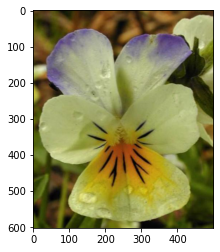

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(open_image(os.path.join(DATA_DIR, files[2])))

In [10]:
from torch.utils.data import Dataset

class FlowersDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root                                              # Define the root directory where the images are found
        self.files = [parse_img_names(fname) for fname in img_names]  # Extract filenames from img_names
        self.classes = classes                                        # Obtain the list of classes as manually imported above
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]                     # Get the image filename
        fpath = os.path.join(self.root, fname)    # Get the filepath by joining the root directory and the filename
        img = self.transform(open_image(fpath))   # Open the image and apply any specified transforms
        class_idx = label_idx[i]                  # Get the corresponding label id for the image
        return img, class_idx

In [11]:
class Pad2Square:
  	def __call__(self, img):
		  h, v = img.size
		  max_dim = max([h, v])
		  h_pad = int((max_dim - h) / 2)
		  v_pad = int((max_dim - v) / 2)
		  padding = (h_pad, v_pad, h_pad, v_pad)
		  return T.functional.pad(img, padding, 0, 'reflect')

In [12]:
!pip install torchtoolbox

In [13]:
from torchtoolbox.transform import Cutout

In [14]:
import torchvision.transforms as T
# apply cutout on dataset

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     # Normalisation parameters used by the imagenet dataset that the model has been pre-trained on
dataset = FlowersDataset(DATA_DIR, T.Compose([Pad2Square(),                   # Pad image to a square shape
                                           T.Resize(img_size),                # Resize to 224x224
                                           Cutout(),
                                           T.Pad(8, padding_mode='reflect'),  # Pad image by 8 pixels
                                           T.RandomCrop(img_size),            # Randomly crop back to 224x224
                                           T.ToTensor(),                      # Convert image to tensor
                                           T.Normalize(*imagenet_stats)])) 

In [15]:
len(dataset), len(dataset.classes)

(8186, 102)

In [16]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)


Label: cape flower (36)


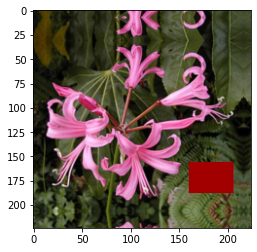

In [17]:
show_image(*dataset[11])

In [18]:
from torch.utils.data import random_split

In [19]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [20]:
len(train_ds), len(valid_ds)

(7368, 818)

In [21]:
from torch.utils.data import DataLoader
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

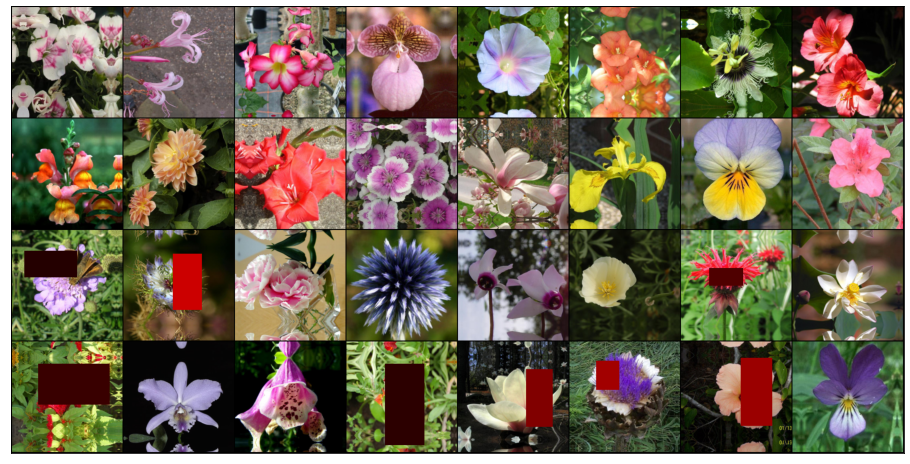

In [23]:
show_batch(train_dl)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)      # Prediction is the output having the highest probability
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) # Calculate accuracy based on the proportion of correct predictions


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses into mean for all batches
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies into mean for all batches
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}   # Return the overall validation loss and accuracy at the end of the epoch

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [25]:
from torchvision import models

class FlowerClassificationModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [30]:
model = FlowerClassificationModel(len(dataset.classes))
to_device(model, device);

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.005144230555742979, 'val_loss': 4.70695161819458}]

In [32]:
epochs = 12
max_lr = 0.0013
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adamax

In [33]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00027, train_loss: 3.2947, val_loss: 1.5342, val_acc: 0.6879


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00078, train_loss: 0.9459, val_loss: 0.7356, val_acc: 0.8222


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00122, train_loss: 0.5888, val_loss: 0.7519, val_acc: 0.7982


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00129, train_loss: 0.5495, val_loss: 0.5342, val_acc: 0.8534


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00121, train_loss: 0.3845, val_loss: 0.5660, val_acc: 0.8262


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00106, train_loss: 0.2884, val_loss: 0.5623, val_acc: 0.8491


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00084, train_loss: 0.1961, val_loss: 0.2805, val_acc: 0.9320


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00060, train_loss: 0.1128, val_loss: 0.2085, val_acc: 0.9365


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00037, train_loss: 0.0882, val_loss: 0.1731, val_acc: 0.9525


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00017, train_loss: 0.0618, val_loss: 0.1322, val_acc: 0.9609


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00004, train_loss: 0.0424, val_loss: 0.1150, val_acc: 0.9648


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00000, train_loss: 0.0407, val_loss: 0.1168, val_acc: 0.9756
CPU times: user 6min 57s, sys: 2min 48s, total: 9min 45s
Wall time: 19min 37s


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

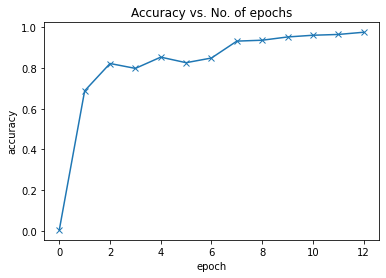

In [35]:
plot_accuracies(history)


In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

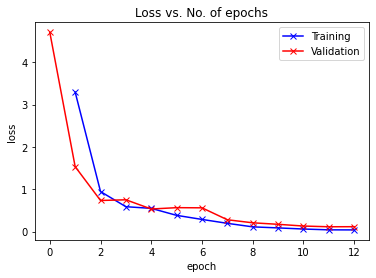

In [37]:
plot_losses(history)

In [38]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

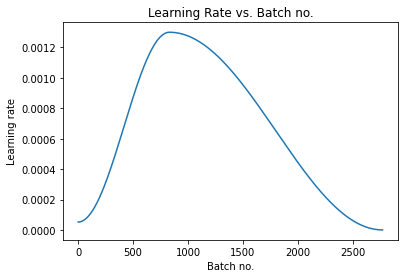

In [39]:
plot_lrs(history)